In [13]:
using CLOUD.ConservationLaws
using CLOUD.SpatialDiscretizations
using CLOUD.Solvers
using CLOUD.InitialConditions
using CLOUD.Mesh
using CLOUD.IO
using OrdinaryDiffEq

"Set up paths"
plots_path = "../plots/advection1d_demo/"
results_path = "../results/advection1d_demo/"

"Define the physical problem"
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 2*π/L  # wave number
T = 1*L/a  # end time

# constant-coefficient linear adection equation with sine wave initial condition
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a)
u_exact = initial_condition(initial_data, conservation_law)

"Set discretization parameters"
M = 20  # number of elements
p = 2  # degree of discretization
N_q = 3  # number of quadrature point
reference_approximation=ReferenceApproximation(DGSEM(p), 
    Line(), LGQuadrature())
form = StrongConservationForm()

"Generate a uniform periodic mesh"
mesh = uniform_periodic_mesh(reference_approximation.reference_element, 
    (0.0,L), M)

"Construct spatial discretization"
spatial_discretization = SpatialDiscretization(mesh, reference_approximation)
    
ode_problem = semidiscretize(conservation_law, 
    spatial_discretization,
    initial_data, form,
    (0.0, T));

In [14]:
"run the solver"
sol = solve(ode_problem, RK4(), dt=T/200.0);

sol

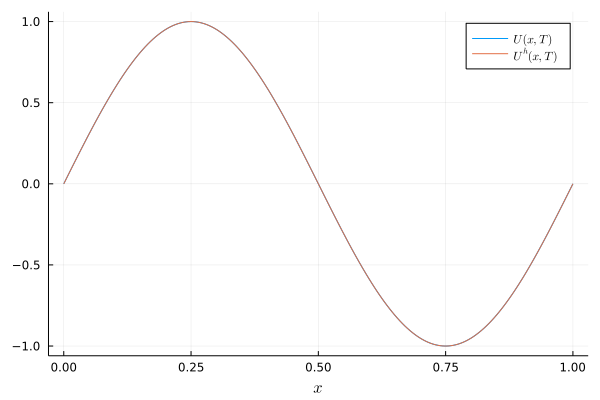

In [15]:
"visualize the solution"
plotter = Plotter(spatial_discretization, plots_path)
visualize(last(sol.u), plotter,
    "final.pdf", exact_solution=u_exact,
     label="U^h(x,T)", label_exact="U(x,T)")